Считывание данных из csv файлов и запись в pandas dataframe

In [2]:
#1
import pandas as pd
import numpy as np

matches = pd.read_csv('FIFAWorldCup2018Matches.csv')
lineups = pd.read_csv('FIFAWorldCup2018Lineups.csv')
passes = pd.read_csv('FIFAWorldCup2018Passes.csv')
shots = pd.read_csv('FIFAWorldCup2018Shots.csv')

В дальнейшем нам часто будет необходимо вывести информацию о каком-либо матче по его id.
<br>
Напишем функцию matchInfo(match_id), которая будет возвращать информацию о матче (Страны команд, счёт матча, группа). Например, результат будет в таком виде:
<br>
Russia - Saudi Arabia (5 - 0, Group A)

In [3]:
#2
def matchInfo(match_id):
    match = matches[matches['match_id'] == match_id].iloc[0]
    
    home_team = match['home_team_name']
    home_score = match['home_score']
    home_team_group = match['home_team_group']
    
    away_team = match['away_team_name']
    away_score = match['away_score']
    
    competition_stage = match['competition_stage_name']
    
    if pd.isna(home_team_group):
        return f'{home_team} - {away_team} ({home_score} - {away_score}, {competition_stage})'
    else:
        return f'{home_team} - {away_team} ({home_score} - {away_score}, {home_team_group})'

Посчитаем сколько всего было забито голов. Для этого создаем отдельный столбец c суммой
голов по каждому матчу, в который суммируем home_score и away_score, то есть
сколько забили домашняя и гостевые команды. Далее округляем до трех знаков и
выводим описательные статистики.

In [4]:
#3
matches['total_score'] = matches['home_score'] + matches['away_score']

pd.set_option('display.float_format', lambda x: '%.3f' % x)
matches['total_score'].describe()

count   64.000
mean     2.641
std      1.577
min      0.000
25%      1.750
50%      2.000
75%      3.000
max      7.000
Name: total_score, dtype: float64

Изобразим гистограмму показателя, сосчитанного на предыдущем шаге

In [5]:
#4
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({'font.size': 10})
plt.subplots(figsize=(11, 9))
graph = sns.countplot(matches['total_score'], color='cornflowerblue')
graph.set_xlabel('Число голов')
graph.set_ylabel('Число матчей')

y_ax = graph.axes.get_yaxis()
y_ax.set_major_locator(MaxNLocator(integer=True))


Видим, что в самом нерезультативном матче было забито 0 голов, такой матч всего один. В самых
результативных матчах – 7 голов, таких матча три. 3 мяча было забито наибольшее количество раз – 19.

Теперь выведем список самых результативных и нерезультативных матчей. 
Из графика выше видно, что самые результатвиные матчи имеют 7 голов, самые нерезультативные 0. По этим критериям и будем делать выборку:

In [6]:
#5
print(matches[matches['total_score'] == 7]['match_id'].apply(matchInfo))
print(matches[matches['total_score'] == 0]['match_id'].apply(matchInfo))

14    France - Argentina (4 - 3, Round of 16)
44         Belgium - Tunisia (5 - 2, Group G)
47          England - Panama (6 - 1, Group G)
Name: match_id, dtype: object
39    Denmark - France (0 - 0, Group C)
Name: match_id, dtype: object


Рассмотрим таблицу lineups, в ней перечислены игроки принимавшие участие в каждом матче. Также известно, что в одном матче допускается не более трёх замен в каждой команде (и одна дополнительная замена в дополнительное время).
<br>
Соответственно, в одной игре может принимать участие не более 14-15 игроков с каждой стороны, и обычно все замены осуществляются.
<br>
Попробуем вывести список матчей и команд, которые делали меньше 3-х замен:

In [7]:
#6
df_subs = lineups.pivot_table('player_name', index=['match_id', 'team_name'], aggfunc='count').reset_index()
df_subs = df_subs[df_subs['player_name'] < 14]
df_subs = df_subs.rename(columns={'match_id': 'match', 'team_name': 'team', 'player_name': 'subs'})
df_subs['match'] = df_subs['match'].apply(matchInfo)
df_subs['subs'] = df_subs['subs'].apply(lambda x: x - 11)
print(df_subs)

                                         match          team  subs
39        Denmark - Australia (1 - 1, Group C)       Denmark     2
44       Serbia - Switzerland (1 - 2, Group E)        Serbia     2
63       Saudi Arabia - Egypt (2 - 1, Group A)  Saudi Arabia     2
84          England - Belgium (0 - 1, Group G)       Belgium     2
85          England - Belgium (0 - 1, Group G)       England     2
89             Japan - Poland (0 - 1, Group H)        Poland     2
106       Belgium - Japan (3 - 2, Round of 16)       Belgium     2
107       Belgium - Japan (3 - 2, Round of 16)         Japan     2
111  Sweden - Switzerland (1 - 0, Round of 16)   Switzerland     2
114   Brazil - Belgium (1 - 2, Quarter-finals)       Belgium     2
121      France - Belgium (1 - 0, Semi-finals)        France     2
126            France - Croatia (4 - 2, Final)       Croatia     2


Теперь вычислим долю точных передач среди всех передач (таблица - passes, (передача считается точной, если её outcome_id отсутствует). 
<br>
А также по группам
передач по разным направлениям: вперёд, назад, поперечные. Будем считать передачу
передачей вперёд, если её угол (angle) лежит между −𝜋/4 и 𝜋/4, поперечной, если угол
между 𝜋/4 и 3𝜋/4 или между −3𝜋/4 и −𝜋/4, остальные — передачи назад.

In [8]:
#7
import math 


def check_direction(angle):
    if -math.pi / 4 <= angle <= math.pi / 4:
        return 'forward'
    elif (math.pi * 3 / 4 > angle > math.pi / 4) or (-math.pi * 3 / 4 < angle < -math.pi / 4):
        return 'accross'
    else:
        return 'backward'


print(passes['outcome_id'].isna().sum()/len(passes['outcome_id']))

passes['direction'] = passes['angle'].apply(check_direction)
df = passes.groupby('direction').count()[['match_id', 'outcome_id']]
print((df['match_id'] - df['outcome_id']) / df['match_id'])

0.7977955210586588
direction
accross    0.852
backward   0.949
forward    0.631
dtype: float64


Из полученых значений можно сделать вывод, что как и практически в любом футбольном матче, пасы назад самые точные, так как в основном им не сильно мешают соперники, а пасы
вперед самые неточные, так как их реализации мешают защитники и другие игроки
соперников. Среднее количество точных передач достаточно высокое – 80%, что
свидетельствует о высоком уровне команд, принимавших участие в ЧМ-2018 по
футболу.

Найдём по пять команд с самыми высокими и самыми низкими долями точных передач:

In [9]:
#8
df = passes[['match_id', 'outcome_id', 'team_name']].groupby('team_name').count()
df = (df['match_id'] - df['outcome_id']) / df['match_id']
print(df.nlargest(n=5))
print(df.nsmallest(n=5))

team_name
Spain          0.894
Germany        0.855
Brazil         0.854
Belgium        0.847
Saudi Arabia   0.845
dtype: float64
team_name
Iran      0.594
Iceland   0.654
Russia    0.689
Sweden    0.707
Senegal   0.731
dtype: float64


5 команд с наименьшей точностью передач: Сенегал, Швеция, Россия, Исландия и
Иран. Невысокий показатель сборной России может быть связан с тем, что она
сыграла среди этих команд наибольшее количество раз, так как дошла до 1/4
финала, обыграв Испанию и уступив Хорватии. Это команды знаменитые своими
защитниками и полузащитниками, которые перехватывают большое количество
передач. У остальных команд показатель напрямую связан с уровнем их сборных.

Теперь сравним распределение длины точных и неточных передач. Для этого построим
гистограммы длины передачи по группам точных и неточных передач.

[Text(0, 0.5, 'Частота'), Text(0.5, 0, 'Длина паса, ярды')]

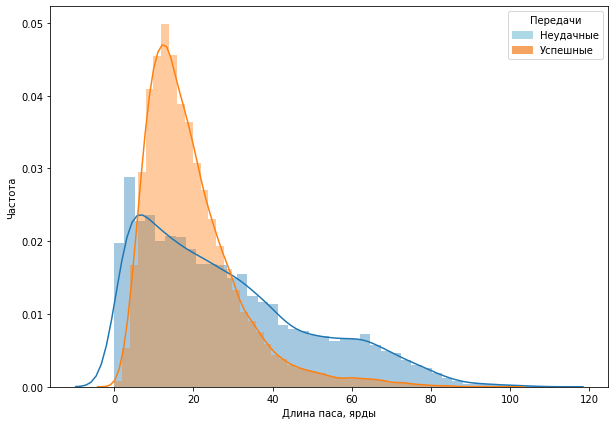

In [10]:
#9
import matplotlib.patches as mpatches


unsuccessful_patch = mpatches.Patch(color='lightblue')
successful_patch = mpatches.Patch(color='sandybrown')

successful = passes[['length', 'outcome_id']][passes['outcome_id'].isna()]
unsuccessful = passes[['length', 'outcome_id']][passes['outcome_id'].notna()]

plt.subplots(figsize=(10, 7))
plt.legend(handles=[unsuccessful_patch, successful_patch], title='Передачи', labels=['Неудачные', 'Успешные'])

hist_unsuccessful = sns.distplot(unsuccessful['length']) 
hist_successful = sns.distplot(successful['length']) 

hist_successful.set(xlabel='Длина паса, ярды', ylabel='Частота')

Вывод очевиден: чем длиннее передача, тем больше вероятность, что она будет
неточной. На коротких расстояниях передачи чаще являются точными.

Сосчитаем среднее число успешных передач за матч для каждой из 32 команд-участниц:

In [11]:
#10
temp = passes.groupby('team_name').count()
count_successful = temp['match_id'] - temp['outcome_id']

teams = pd.concat([matches['home_team_name'], matches['away_team_name']])
teams_count = teams.groupby(teams).count()

avgnumpasses = count_successful / teams_count
avgnumpasses.head()

team_name
Argentina   508.500
Australia   424.333
Belgium     457.429
Brazil      495.200
Colombia    381.750
dtype: float64

Сосчитаем среднее число забитых голов за матч для каждой из 32 команд-участниц

In [12]:
#11
home_goals = matches[['home_team_name', 'home_score']].groupby('home_team_name').sum()
away_goals = matches[['away_team_name', 'away_score']].groupby('away_team_name').sum()

sum_goals = home_goals['home_score'] + away_goals['away_score']
avgnumgoals = sum_goals / teams_count

avgnumgoals.head()

home_team_name
Argentina   1.500
Australia   0.667
Belgium     2.286
Brazil      1.600
Colombia    1.500
dtype: float64

Теперь, используя результаты пунктов 10 и 11, нарисуем регрессионную диаграмму, показывающую, есть ли связь между средним числом успешных передач и средним числом забитых мячей.

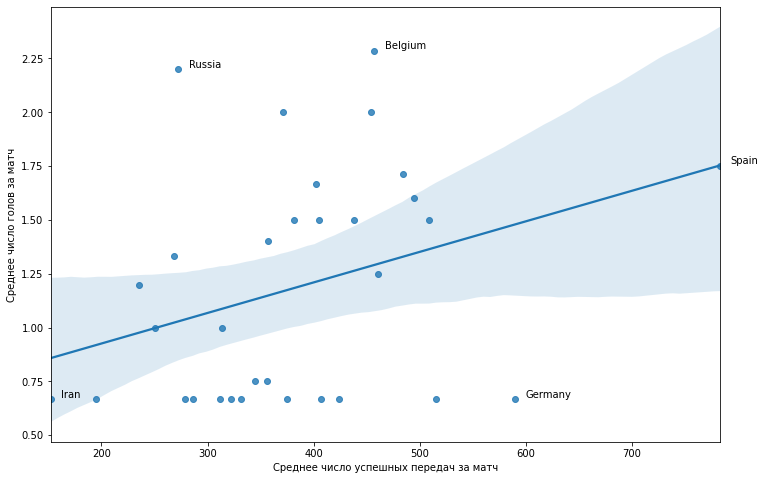

In [13]:
#12
plt.subplots(figsize=(12, 8))
ax = sns.regplot(x=avgnumpasses, y=avgnumgoals)
ax.set(xlabel='Среднее число успешных передач за матч', ylabel='Среднее число голов за матч')

markers = ['Russia', 'Belgium', 'Germany', 'Iran', 'Spain']

for marker in markers:
    ax.text(avgnumpasses[marker] + 10, avgnumgoals[marker], marker, va='bottom', ha='left')

По диаграмме видно, что чёткой взаимосвязи на этом наборе данных нет, так как, например, если
соединить показания для сборных Ирана и Германии, то получаем 12 команд с
одинаковым количеством голов за матч, при этом огромной разницей в среднем
числе передач за матч. Так же в диапазоне 300-400 передач диапазон голов тоже
высок, у кого-то около 0,6-0,7, у других же команд свыше полутора.

Рассмотрим таблицу shots. Подобно пункту 9 изобразим на одной диаграмме две
гистограммы расстояний, с которых наносятся удачные и неудачные удары. Также заметим, что
данные устроены так, что атакующая команда всегда атакует «направо» и наносит удары в
«правые» ворота. Кроме того, в данных содержатся всевозможные удары по воротам, даже в послематчевых пенальти (такие удары можно определить по полю period, равному 5). Удалим из данных все удары с послематчевых пенальти.

0   17.029
1   28.000
2   19.849
3   15.000
4   17.464
Name: distance, dtype: float64


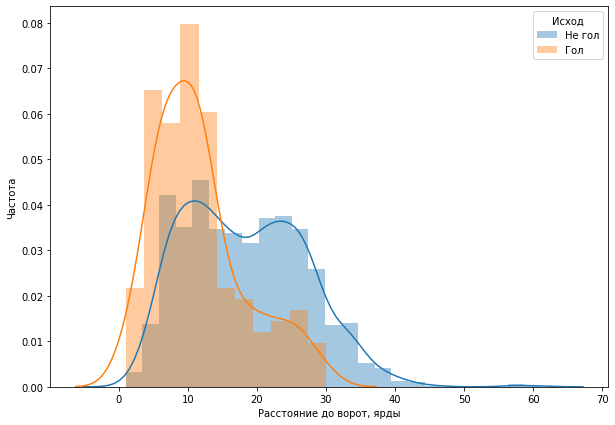

In [14]:
#13
# Функция для расчёта расстояния до ближайшего створа ворот
def distance(x, y):
    if y < 36:
        return ((120 - x) ** 2 + (36 - y) ** 2) ** 0.5
    elif 36 <= y <= 44:
        return 120 - x
    elif y > 44:
        return ((120 - x) ** 2 + (y - 44) ** 2) ** 0.5


shots_main_period = shots[shots['period'] < 5].copy()

shots_main_period['distance'] = shots_main_period['location_x'].combine(shots_main_period['location_y'], distance)
print(shots_main_period['distance'].head())

successful = shots_main_period[shots_main_period['outcome_name'] == 'Goal']
unsuccessful = shots_main_period[shots_main_period['outcome_name'] != 'Goal']

plt.subplots(figsize=(10, 7))

ax1 = sns.distplot(unsuccessful['distance'])
ax2 = sns.distplot(successful['distance'])

ax1.set(xlabel='Расстояние до ворот, ярды', ylabel='Частота')
plt.legend(title='Исход', labels=['Не гол', 'Гол'])


Найдём матч, в котором было совершено больше всего ударов по воротам (опять же
без учета послематчевых пенальти).

In [15]:
#14
shcounts = shots_main_period.groupby('match_id').count().reset_index()
shcounts = shcounts[['match_id', 'id']]
shcounts = shcounts.rename(columns={'id': 'shots_count'})
shcounts['match_info'] = shcounts['match_id'].apply(matchInfo)
shcounts.nlargest(1, 'shots_count')

,match_id,shots_count,match_info
39,7567,41,"South Korea - Germany (2 - 0, Group F)"


Теперь нарисуем диаграмму рассеивания, на которой изобразим точки, с которых наносились удары в матче, найденном в предыдущем пункте. Раскрасим точки в соответствии с исходами ударов.

In [20]:
#15
max_shots_match = shots[shots['match_id'] == 7567]
max_shots_match = max_shots_match.rename(columns={'outcome_name': 'Outcome'})
home_team_shots = max_shots_match[max_shots_match['team_name'] == 'South Korea'].copy()
away_team_shots = max_shots_match[max_shots_match['team_name'] == 'Germany'].copy()

away_team_shots['location_x'] = away_team_shots['location_x'].apply(lambda x: 120 - x)
away_team_shots['location_y'] = away_team_shots['location_y'].apply(lambda y: 80 - y)




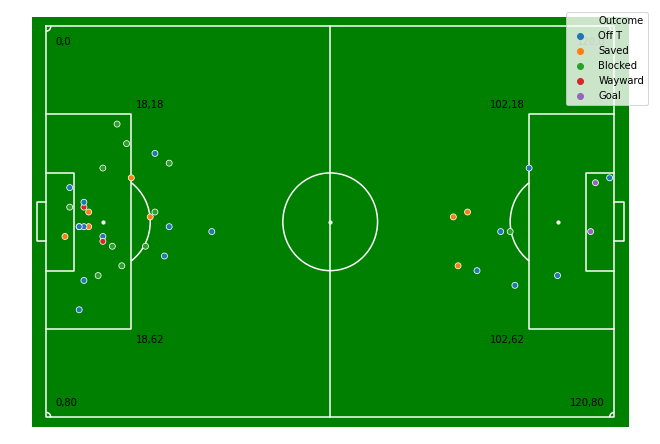

In [25]:
import matplotlib.pyplot as plt
from pitch import plotPitch

plt.figure(figsize=(9, 6))
plotPitch(True)
plt.tight_layout(0.1)

sns.scatterplot(x=pd.concat([away_team_shots['location_x'], home_team_shots['location_x']]),
                y=pd.concat([away_team_shots['location_y'], home_team_shots['location_y']]),
                hue=pd.concat([away_team_shots['Outcome'], home_team_shots['Outcome']]))
plt.show()